# 08 ODE integrators: Verlet

In [1]:
from importlib import reload

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

import integrators2

In [2]:
reload(integrators2)

<module 'integrators2' from '/home/oliver/Documents/Teaching/ASU/PHY494/2016/Lectures/08_ODEs/integrators2.py'>

## Velocity Verlet

Use expansion *forward* and *backward* (!) in time (Hamiltons (i.e. Newton without friction) equations are time symmetric)

\begin{align}
r(t + \Delta r) &\approx r(t) + \Delta t\, v(t) + \frac{1}{2m} \Delta t^2 F(t)\\
r(t) &\approx r(t + \Delta t) - \Delta t\, v(t + \Delta t) + \frac{1}{2m} \Delta t^2 F(t+\Delta t)
\end{align}

Solve for $v$:
\begin{align}
v(t+\Delta t) &\approx v(t) + \frac{1}{2m} \Delta t \big(F(t) + F(t+\Delta t)\big)
\end{align}

Complete **Velocity Verlet** integrator consists of the first and third equation.

In practice, split into three steps (calculate the velocity at the half time step):
\begin{align}
v(t+\frac{\Delta t}{2}) &= v(t) + \frac{\Delta t}{2} \frac{F(t)}{m} \\
r(t + \Delta r) &= r(t) + \Delta t\, v(t+\frac{\Delta t}{2})\\
v(t+\Delta t) &= v(t+\frac{\Delta t}{2}) + \frac{\Delta t}{2} \frac{F(t+\Delta t)}{m}
\end{align}

When writing production-level code, remember to re-use $F(t+\Delta t)$ als the "new" starting $F(t)$ in the next iteration (and don't recompute).

### Integration of planetary motion 
Gravitational potential energy:
$$
U(r) = -\frac{GMm}{r}
$$
with $r$ the distance between the two masses $m$ and $M$.

#### Central forces
$$
U(\mathbf{r}) = f(r) = f(\sqrt{\mathbf{r}\cdot\mathbf{r}})\\
\mathbf{F} = -\nabla U(\mathbf{r}) = -\frac{\partial f(r)}{\partial r} \, \frac{\mathbf{r}}{r} 
$$

#### Force of gravity
\begin{align}
\mathbf{F} &= -\frac{G m M}{r^2} \hat{\mathbf{r}}\\
\hat{\mathbf{r}} &= \frac{1}{\sqrt{x^2 + y^2}} \left(\begin{array}{c} x \\ y \end{array}\right)
\end{align}

#### Integrate simple planetary orbits 
Set $$GM = 1$$ and try initial conditions
$$
x(0) = 0.5, \quad y(0)=0, \quad v_x(0)=0, \quad v_y(0)=1.63
$$

In [3]:
def F_gravity(r, m=1, G=1, M=1):
    rr = np.sum(r*r)
    rhat = r/np.sqrt(rr)
    return - G*m*M/rr * rhat

def U_gravity(r, m=1, G=1, M=1):
    return -G*m*M/np.sqrt(np.sum(r*r))

Let's now integrate the equations of motions under gravity with the **Velocity Verlet** algorithm:

In [8]:
# 2D planetary motion with velocity verlet
dim = 2

r0 = np.array([0.5, 0])
v0 = np.array([0, 1.63])
mass = 1

dt = 0.01
t_max = 2000
nsteps = int(t_max/dt)

r = np.zeros((nsteps, dim))
v = np.zeros_like(r)

r[0, :] = r0
v[0, :] = v0

# start force evaluation for first step
Ft = F_gravity(r[0], m=mass)
for i in range(nsteps-1):
    vhalf = v[i] + 0.5*dt * Ft/mass
    r[i+1, :] = r[i] + dt * vhalf
    Ftdt = F_gravity(r[i+1], m=mass)
    v[i+1] = vhalf + 0.5*dt * Ftdt/mass
    # new force becomes old force
    Ft = Ftdt

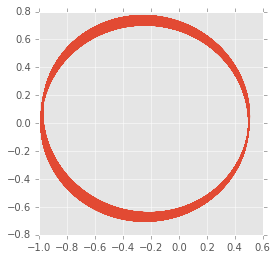

In [5]:
rx, ry = r.T
ax = plt.subplot(1,1,1)
ax.set_aspect(1)
ax.plot(rx, ry)

These are not closed orbits (as we would expect from a $1/r$ potential). But gets much besser when stepsize is reduced to 0.001 (just rerun the code with `dt = 0.001` and replot):

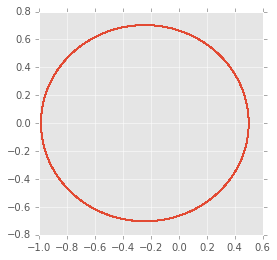

In [7]:
rx, ry = r.T
ax = plt.subplot(1,1,1)
ax.set_aspect(1)
ax.plot(rx, ry)

## Velocity Verlet vs RK4: Energy conservation
Assess the stability of `rk4` and `Velocity Verlet` by checking energy conservation over longer simulation times.

The file `integrators2.py` contains almost all code that you will need.

### Implement gravity force in `integrators2.py`
Add `F_gravity` to the `integrators2.py` module. Use the new function `unitvector()`.

### Planetary orbits with `integrators2.py` 

In [9]:
r0 = np.array([0.5, 0])
v0 = np.array([0, 1.63])

In [10]:
import integrators2
from importlib import reload
reload(integrators2)

<module 'integrators2' from '/home/oliver/Documents/Teaching/ASU/PHY494/2016/Lectures/08_ODEs/integrators2.py'>

Use the new function `integrators2.integrate_newton_2d()` to integrate 2d coordinates.

#### RK4

In [11]:
trk4, yrk4 = integrators2.integrate_newton_2d(x0=r0, v0=v0, t_max=100, mass=1,
                                       h=0.01,
                                       force=integrators2.F_gravity, 
                                       integrator=integrators2.rk4)

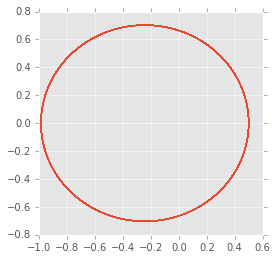

In [12]:
rxrk4, ryrk4 = yrk4[:, 0, 0], yrk4[:, 0, 1]
ax = plt.subplot(1,1,1)
ax.set_aspect(1)
ax.plot(rxrk4, ryrk4)

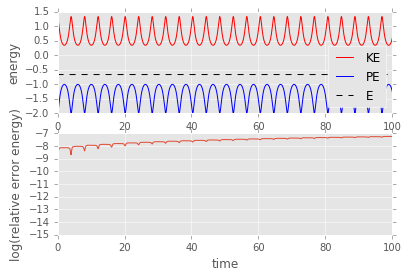

In [13]:
integrators2.analyze_energies(trk4, yrk4, integrators2.U_gravity)

In [14]:
print("Energy conservation RK4 for {} steps: {}".format(
        len(trk4),
        integrators2.energy_conservation(trk4, yrk4, integrators2.U_gravity)))

Energy conservation RK4 for 10000 steps: 3.1024529030543314e-08


#### Euler

In [15]:
te, ye = integrators2.integrate_newton_2d(x0=r0, v0=v0, t_max=100, mass=1,
                                         h=0.01,
                            force=F_gravity, 
                            integrator=integrators2.euler)
rex, rey = ye[:, 0].T

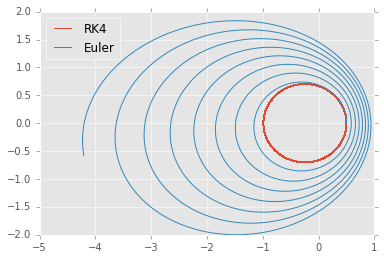

In [16]:
ax = plt.subplot(1,1,1)
ax.plot(rx, ry, label="RK4")
ax.plot(rex, rey, label="Euler")
ax.legend(loc="best")

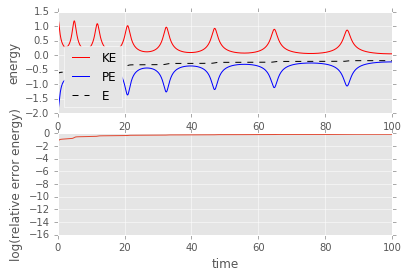

In [17]:
integrators2.analyze_energies(te, ye, integrators2.U_gravity)

In [18]:
print("Energy conservation Euler for {} steps: {}".format(
        len(te),
        integrators2.energy_conservation(te, ye, integrators2.U_gravity)))

Energy conservation Euler for 10000 steps: 0.5605123538775403


*Euler* is just awful... but we knew that already.

#### Velocity Verlet

In [19]:
tv, yv = integrators2.integrate_newton_2d(x0=r0, v0=v0, t_max=100, mass=1,
                                       h=0.01,
                                       force=F_gravity, 
                                       integrator=integrators2.velocity_verlet)

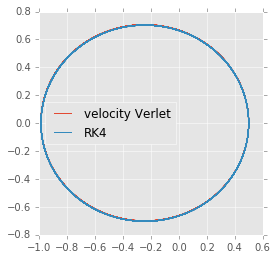

In [20]:
rxv, ryv = yv[:, 0].T
ax = plt.subplot(1,1,1)
ax.set_aspect(1)
ax.plot(rxv, ryv, label="velocity Verlet")
ax.plot(rxrk4, ryrk4, label="RK4")
ax.legend(loc="best")

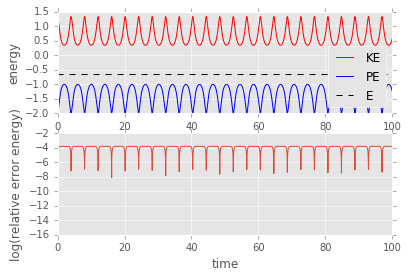

In [21]:
integrators2.analyze_energies(tv, yv, integrators2.U_gravity)

In [23]:
print("Energy conservation Velocity Verlet for {} steps: {}".format(
        len(tv),
        integrators2.energy_conservation(tv, yv, integrators2.U_gravity)))

Energy conservation Velocity Verlet for 10000 steps: 0.00013636604665819108


*Velocity Verlet* only has moderate accuracy, especially when compared to *RK4*.

However, let's look at energy conservation over longer times:

#### Longer time scale stability
Run RK4 and Velocity Verlet for longer.

In [24]:
tv2, yv2 = integrators2.integrate_newton_2d(x0=r0, v0=v0, t_max=5000, mass=1,
                                       h=0.01,
                                       force=F_gravity, 
                                       integrator=integrators2.velocity_verlet)

In [25]:
print("Energy conservation Velocity Verlet for {} steps: {}".format(
        len(tv2),
        integrators2.energy_conservation(tv2, yv2, integrators2.U_gravity)))

Energy conservation Velocity Verlet for 500000 steps: 0.00013607757833750982


In [26]:
t4, y4 = integrators2.integrate_newton_2d(x0=r0, v0=v0, t_max=5000, mass=1,
                                       h=0.01,
                                       force=F_gravity, 
                                       integrator=integrators2.rk4)

In [27]:
print("Energy conservation RK4 for {} steps: {}".format(
        len(t4),
        integrators2.energy_conservation(t4, y4, integrators2.U_gravity)))

Energy conservation RK4 for 500000 steps: 1.284583166417538e-06


Velocity Verlet shows **good long-term stability** but relative low precision. On the other hand, RK4 has high precision but the accuracy decreases over time.

* Use a *Verlet* integrator when energy conservation is important and long term stability is required (e.g. molecular dynamics simulations). It is generally recommended to use an integrator that conserves some of the inherent symmetries and structures of the governing physical equations (e.g. for Hamilton's equations of motion, time reversal symmetry and the symplectic and area-preserving structure).
* Use *RK4* for high short-term accuracy (but may be difficult to know what "short term" should mean) or when solving general differential equations.
